In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np
factorial = np.math.factorial
import copy
import matplotlib.pyplot as plt

# custom module where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform # isoprobabilistic transform

# custom module
import Surrogates.PolynomialChaosExpansion as PCE
import Surrogates.KarhunenLoeveExpansion as KLE

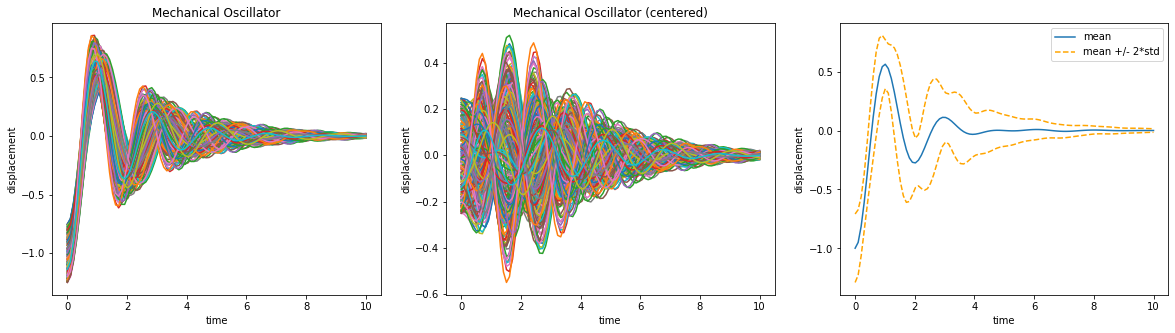

In [3]:
N = 20_000 # number of 'instances'/'realisations'

t = np.linspace(0, 10, 100) # row vector
T = np.tile(t, (N, 1)) # repeat row 't' along axis 0

SampleSpace = mech_oscillator_samples(N) # generate samples

Y = mech_oscillator(SampleSpace, T) # compute output (displacement) [n, N_quad]

Y_mean = np.mean(Y, axis=0) # compute mean for each t_i
Y_std = np.std(Y, axis=0) # compute std for each t_i

# center the process
Y_c = Y-Y_mean

'Plots'
fig, ax = plt.subplots(1, 3, figsize=(20,5))

'Plot 200 realisations of the random process'
for i in np.arange(200):
    ax[0].plot(t,Y[i,:], '-')
ax[0].set_ylabel('displacement')
ax[0].set_xlabel('time')
ax[0].set_title('Mechanical Oscillator')

for i in np.arange(200):
    ax[1].plot(t,Y_c[i,:], '-')
ax[1].set_ylabel('displacement')
ax[1].set_xlabel('time')
ax[1].set_title('Mechanical Oscillator (centered)')

'Plot the mean and 2 stds of random process'
ax[2].plot(t,Y_mean, '-', label = 'mean')
ax[2].plot(t,Y_mean+2*Y_std, '--', color = 'orange', label = 'mean +/- 2*std')
ax[2].plot(t,Y_mean-2*Y_std, '--', color = 'orange')
ax[2].set_ylabel('displacement')
ax[2].set_xlabel('time')
ax[2].legend()

plt.show()

# Surrogate

Variance quantified by 10 terms = 0.9999956800075976


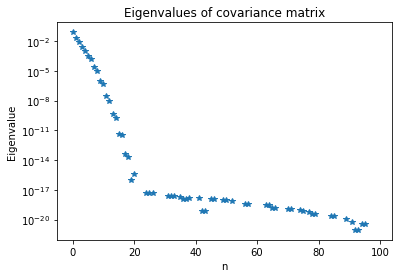

Number of PCE terms: 286
Number of evaluations needed (empirical estimate): 572
Number of function evaluations: 20000


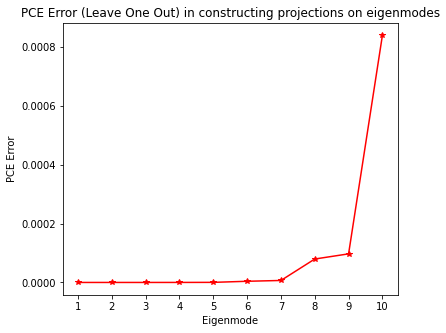

In [5]:
total_polynomial_degree = 10

number_of_random_variables = 3
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

# truncation level for KLE
n_kl = 6

test = KLE.KLE(SampleSpace, Y, t, total_polynomial_degree, n_kl, polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform, True)

# test.plot_eigenvectors() # only even n_kl
# test.plot_projections() # only even n_kl

# Validation

In [5]:
SampleSpace_test = mech_oscillator_samples(N) # generate samples

Y_test = mech_oscillator(SampleSpace_test, T) # compute output (displacement) [n, N_quad]

Y_mean = np.mean(Y_test, axis=0) # compute mean for each t_i
Y_std = np.std(Y_test, axis=0) # compute std for each t_i

# center the process
Y_c = Y-Y_mean

Y_surrogate = test.surrogate_evaluate(SampleSpace_test)

Y_surrogate_mean = np.mean(Y_surrogate, axis=0) # compute mean for each t_i
Y_surrogate_std = np.std(Y_surrogate, axis=0) # compute std for each t_i

# center the process
Y_surrogate_c = Y_surrogate - Y_surrogate_mean

print(f"Relative L2 Error: {np.linalg.norm(Y_surrogate - Y_test)*100/np.linalg.norm(Y_test):.2f}%")

Relative L2 Error: 1.23%


# Total error

In [6]:
error_PCE = np.sum(test.PCE_errors)
error_KLE = np.sum(test.eig_values[n_kl:])

error_total = (np.sqrt(error_PCE) + np.sqrt(error_KLE))**2 * 100

print(f"Total surrogate error: {error_total:.4f}%" )

Total surrogate error: 0.1072%


In [23]:
error_KLE

4.936129023663231e-07

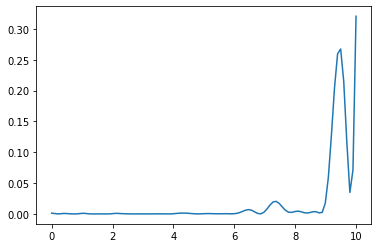

In [7]:
eig_vec_sq = copy.deepcopy(test.eig_vectors)**2
trunc_eig_vec_sq = test.eig_vectors[:,n_kl:]**2 

for i in range(100-n_kl):
    lambda_i = test.eig_values[n_kl+i]
    trunc_eig_vec_sq[:, i] = trunc_eig_vec_sq[:, i] *  lambda_i

for i in range(100):
    lambda_i = test.eig_values[i]
    eig_vec_sq[:, i] = eig_vec_sq[:, i] *  lambda_i

total_var = np.sum(eig_vec_sq, axis=1)
error = np.sum(trunc_eig_vec_sq, axis=1)

plt.plot(t,error *100/total_var, '-')

plt.show()

# Relative Error Plot

In [8]:
# fig, ax = plt.subplots(1, 2, figsize=(14,4))

# # averaged over 20_000 realisations
# pointwise_error = np.square(Y_test - Y_surrogate).mean(axis=0) * 100 / np.square(Y_test).mean(axis=0)

# ax[0].plot(t, Y_test.T)
# ax[0].set_ylabel('displacement')
# ax[0].set_xlabel('time')
# ax[0].set_title('Displacement vs time')
# ax[0].grid()

# ax[1].plot(t, pointwise_error.T)
# ax[1].set_ylabel(r'$\frac{(y - \tilde{y})^2}{y^2}$ * 100')
# ax[1].set_xlabel('time')
# ax[1].set_title('Relative point-wise percentage error')
# ax[1].grid()

# Plot surrogate evaluations

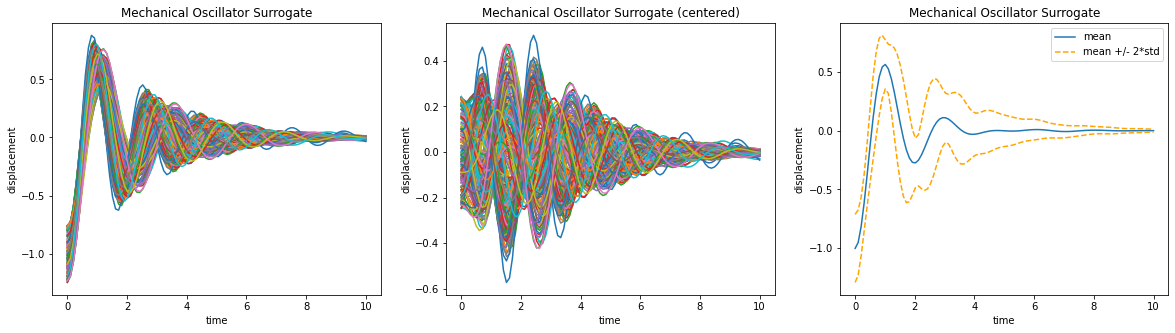

In [9]:
'Plots'
fig, ax = plt.subplots(1, 3, figsize=(20,5))

'Plot 200 realisations of the random process'
for i in np.arange(200):
    ax[0].plot(t,Y_surrogate[i,:], '-')
ax[0].set_ylabel('displacement')
ax[0].set_xlabel('time')
ax[0].set_title('Mechanical Oscillator Surrogate')

for i in np.arange(200):
    ax[1].plot(t,Y_surrogate_c[i,:], '-')
ax[1].set_ylabel('displacement')
ax[1].set_xlabel('time')
ax[1].set_title('Mechanical Oscillator Surrogate (centered)')

'Plot the mean and 2 stds of random process'
ax[2].plot(t,Y_surrogate_mean, '-', label = 'mean')
ax[2].plot(t,Y_surrogate_mean+2*Y_surrogate_std, '--', color = 'orange', label = 'mean +/- 2*std')
ax[2].plot(t,Y_surrogate_mean-2*Y_surrogate_std, '--', color = 'orange')
ax[2].set_ylabel('displacement')
ax[2].set_xlabel('time')
ax[2].set_title('Mechanical Oscillator Surrogate')
ax[2].legend()

plt.show()

# Relative Variance error

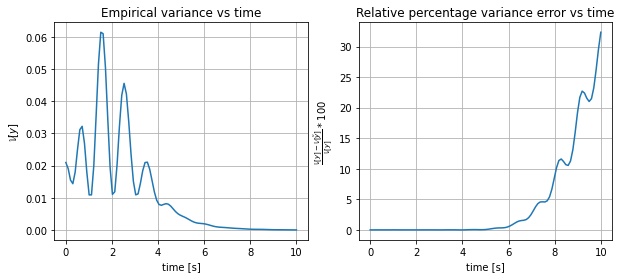

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

pointwise_error_var = (np.var(Y_test, axis=0) - np.var(Y_surrogate, axis=0)) * 100 / np.var(Y_test, axis=0)

# variance of model evals
ax[0].plot(t, np.var(Y_test, axis=0))
ax[0].set_title(r'Empirical variance vs time')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel(r'$\mathbb{V}[y]$')
ax[0].grid()

# variance of model evals - variance of surrogate evals
ax[1].plot(t, pointwise_error_var)
ax[1].set_title(r'Relative percentage variance error vs time')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel(r'$\frac{\mathbb{V}[y] - \mathbb{V}[\tilde{y}]}{\mathbb{V}[y]} * 100$')
ax[1].grid()

# Eigenprojections Histogram

test.Y_i [N, n_kl] are the projections on the eigenbasis.


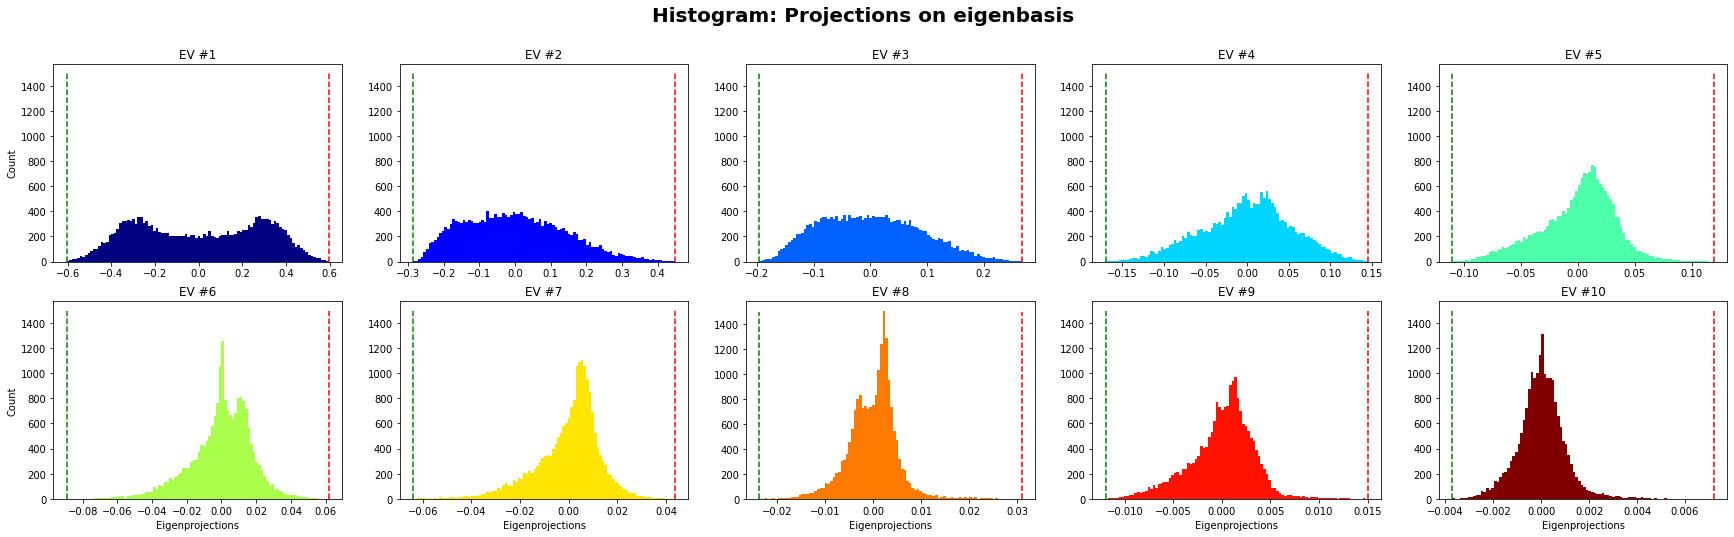

In [11]:
n_bins = 100

# fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 8), sharex=True, sharey=True)
fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 8))

# change colors in for loop
colors = iter(plt.cm.jet(np.linspace(0,1,n_kl)))

for i in np.arange(n_kl):

    row = int(i//(n_kl/2))
    column = int(i%(n_kl/2))

    # choose one column corresponding to projections on ith eigenbasis
    ax[row][column].hist(test.Y_i[:, i], bins=n_bins, color=next(colors))
    ax[row][column].vlines(np.min(test.Y_i[:, i]), ymin = 0, ymax = 1500, color = 'green', linestyle = '--')
    ax[row][column].vlines(np.max(test.Y_i[:, i]), ymin = 0, ymax = 1500, color = 'red', linestyle = '--')

    'Formatting'
    if column == 0:
        ax[row][column].set_ylabel('Count')
    if row == 1:
        ax[row][column].set_xlabel('Eigenprojections')
    
    ax[row][column].set_title('EV #' + str(i+1))

fig.suptitle("Histogram: Projections on eigenbasis", fontsize=20, fontweight= "bold")

plt.show()

# Projection on eigenbasis

In [12]:
# plt.plot(np.linspace(1, n_kl, n_kl), test.Y_i.T)

# plt.xlabel('Eigenmode')
# plt.ylabel('Projection value')
# plt.title('Projection values decrease on higher eigenbasis')
# plt.show()

# Realizations of model vs. Surrogate

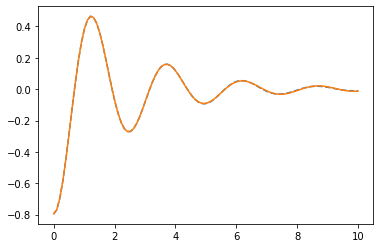

In [13]:
plt.plot(t,Y_test[0,:], '--')
plt.plot(t,Y_surrogate[0,:])